In [24]:
import torch
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import imageio
import seaborn as sns
from sklearn.manifold import TSNE

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda:0


In [27]:
class Generator(nn.Module):
    def __init__(self, z_dimension, number_features, number_channels, number_of_classes):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dimension + z_dimension, number_features * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(number_features * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(number_features * 4, number_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_features * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(number_features * 2, number_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_features),
            nn.ReLU(True),
            nn.ConvTranspose2d(number_features, number_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.embed = nn.Embedding(number_of_classes, z_dimension)

    def forward(self, z, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        z = torch.cat([z, embedding], dim=1) # N C H W
        return self.main(z)
    
class Discriminator(nn.Module):
    def __init__(self, number_disc_features, number_channels, number_of_classes):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels=number_channels + 1, out_channels=number_disc_features, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(in_channels=number_disc_features, out_channels=number_disc_features * 2, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(number_disc_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(in_channels=number_disc_features * 2, out_channels=number_disc_features * 4, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(number_disc_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(in_channels=number_disc_features * 4, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)),
            nn.Sigmoid()
        )
        self.embed = nn.Embedding(number_of_classes, 32*32)

    def forward(self, input, labels):
        embedding = self.embed(labels).view(labels.shape[0],1,32,32)
        input = torch.cat([input, embedding], dim=1) # N C H W
        return self.main(input)


Starting Training Loop...
[0/5][0/469] Loss_D: 1.3389 Loss_G: 1.0789 D(x): 0.5081 D(G(z)): 0.4427 / 0.3469
[0/5][100/469] Loss_D: 0.9977 Loss_G: 1.1423 D(x): 0.5750 D(G(z)): 0.3238 / 0.3269
[0/5][200/469] Loss_D: 1.3871 Loss_G: 1.4041 D(x): 0.5390 D(G(z)): 0.4785 / 0.2529
[0/5][300/469] Loss_D: 1.1283 Loss_G: 1.4721 D(x): 0.5800 D(G(z)): 0.3881 / 0.2455
[0/5][400/469] Loss_D: 0.7990 Loss_G: 1.6839 D(x): 0.7280 D(G(z)): 0.3558 / 0.1885
[1/5][0/469] Loss_D: 0.8590 Loss_G: 1.5945 D(x): 0.6552 D(G(z)): 0.3116 / 0.2121
[1/5][100/469] Loss_D: 0.7120 Loss_G: 1.7564 D(x): 0.7169 D(G(z)): 0.2764 / 0.1885
[1/5][200/469] Loss_D: 0.9505 Loss_G: 1.2636 D(x): 0.6290 D(G(z)): 0.3433 / 0.2940
[1/5][300/469] Loss_D: 1.0625 Loss_G: 1.6071 D(x): 0.6092 D(G(z)): 0.3886 / 0.2109
[1/5][400/469] Loss_D: 0.9026 Loss_G: 1.3972 D(x): 0.6415 D(G(z)): 0.3337 / 0.2614
[2/5][0/469] Loss_D: 0.9331 Loss_G: 1.2207 D(x): 0.5754 D(G(z)): 0.2343 / 0.3073
[2/5][100/469] Loss_D: 0.8473 Loss_G: 1.7140 D(x): 0.7257 D(G(z)): 

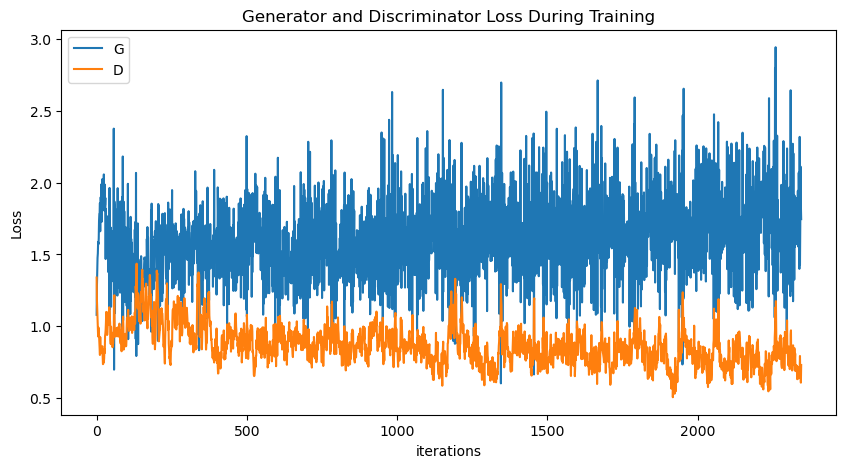

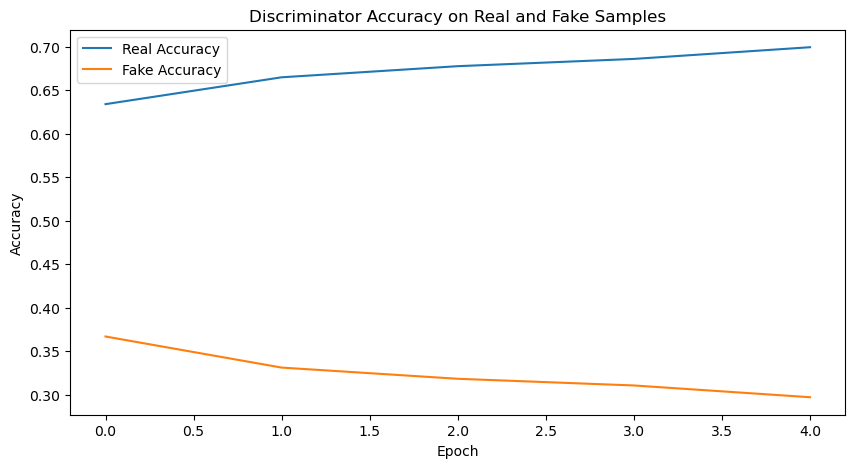

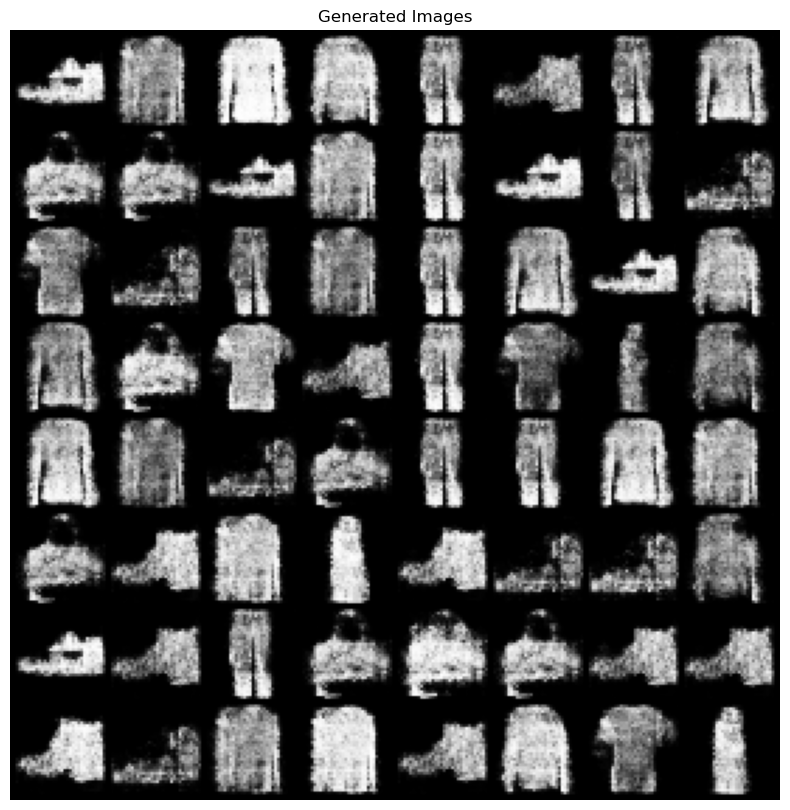

C:\Users\Ilir\AppData\Local\Temp\ipykernel_20168\1176289537.py:142: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'latent_evolution/epoch_{epoch}.png'))


In [15]:
# Hyperparameters
batch_size = 128
image_size = 32
z_dimension = 100
number_features = 64
number_channels = 1
number_disc_features = 64
number_of_classes = 10
lr = 0.0001
beta1 = 0.5

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Instantiate models
generator = Generator(z_dimension, number_features, number_channels, number_of_classes).to(device)
discriminator = Discriminator(number_disc_features, number_channels, number_of_classes).to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

D_losses = []
G_losses = []
img_list = []
D_real_acc_per_epoch = []
D_fake_acc_per_epoch = []

num_epochs=5
fixed_noise = torch.randn(64, z_dimension, 1, 1, device=device)
fixed_labels = torch.randint(0, number_of_classes, (64,), device=device)

print("Starting Training Loop...")

for epoch in range(num_epochs):
    D_real_acc = 0
    D_fake_acc = 0
    total_batches = 0

    for i, (data, labels) in enumerate(dataloader, 0):
        total_batches += 1

        # Update Discriminator
        discriminator.zero_grad()
        real_cpu = data.to(device)
        labels = labels.to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), 1, dtype=torch.float, device=device)
        output = discriminator(real_cpu, labels).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        D_real_acc += D_x

        noise = torch.randn(batch_size, z_dimension, 1, 1, device=device)
        fake = generator(noise, labels)
        label.fill_(0)
        output = discriminator(fake.detach(), labels).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        D_fake_acc += D_G_z1
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        generator.zero_grad()
        label.fill_(1)
        output = discriminator(fake, labels).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}')

        G_losses.append(errG.item())
        D_losses.append(errD.item())
    
    D_real_acc_per_epoch.append(D_real_acc / total_batches)
    D_fake_acc_per_epoch.append(D_fake_acc / total_batches)
        
    # Save images to show the evolution of a single latent code
    with torch.no_grad():
        fake = generator(fixed_noise, fixed_labels).detach().cpu()
    vutils.save_image(fake, f'latent_evolution/epoch_{epoch}.png', normalize=True)

print("Training finished.")

# Plot losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.title("Discriminator Accuracy on Real and Fake Samples")
plt.plot(D_real_acc_per_epoch, label="Real Accuracy")
plt.plot(D_fake_acc_per_epoch, label="Fake Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Generate some images
with torch.no_grad():
    noise = torch.randn(64, z_dimension, 1, 1, device=device)
    labels = torch.randint(0, number_of_classes, (64,), device=device)
    fake = generator(noise, labels).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))
plt.show()

# Create GIF of the evolution of a single latent code
images = []
for epoch in range(num_epochs):
    images.append(imageio.imread(f'latent_evolution/epoch_{epoch}.png'))
imageio.mimsave('latent_evolution.gif', images, fps=2)
    


In [16]:
num_images = 500
generated_images = []
generated_labels = []

for i in range(num_images):
    noise = torch.randn(1, z_dimension, 1, 1, device=device)
    label = torch.randint(0, number_of_classes, (1,), device=device)
    with torch.no_grad():
        fake_image = generator(noise, label).detach().cpu()
    generated_images.append(fake_image)
    generated_labels.append(label.item())

generated_images = torch.cat(generated_images, dim=0)
generated_labels = torch.tensor(generated_labels)

In [30]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, number_of_classes)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Prepare data loaders for training the classifier
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize and train the classifier
classifier = Classifier().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs_classifier = 10

for epoch in range(num_epochs_classifier):
    classifier.train()
    for i, (data, labels) in enumerate(train_loader, 0):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = classifier(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs_classifier}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print('Finished training the classifier.')

# Save the trained classifier
torch.save(classifier.state_dict(), 'fashion_mnist_classifier.pth')


# Reload the classifier
classifier.load_state_dict(torch.load('fashion_mnist_classifier.pth'))
classifier.eval()

# Function to get intermediate features from the classifier
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            model.conv1,
            model.relu,
            model.pool,
            model.conv2,
            model.relu,
            model.pool
        )

    def forward(self, x):
        return self.features(x)

feature_extractor = FeatureExtractor(classifier).to(device)

def extract_features(data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            output = feature_extractor(data).view(data.size(0), -1)
            features.append(output.cpu())
            labels.append(label)
    return torch.cat(features, dim=0), torch.cat(labels, dim=0)

# Extract features for train split, test split, and generated images
train_features, train_labels = extract_features(train_loader)

test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_features, test_labels = extract_features(test_loader)

generated_dataset = [(generated_images[i], generated_labels[i]) for i in range(num_images)]
generated_loader = DataLoader(generated_dataset, batch_size=batch_size, shuffle=False)
generated_features, generated_labels = extract_features(generated_loader)

Epoch [1/10], Step [1/625], Loss: 2.2937
Epoch [1/10], Step [101/625], Loss: 0.8085
Epoch [1/10], Step [201/625], Loss: 0.8444
Epoch [1/10], Step [301/625], Loss: 0.4037
Epoch [1/10], Step [401/625], Loss: 0.5338
Epoch [1/10], Step [501/625], Loss: 0.5532
Epoch [1/10], Step [601/625], Loss: 0.5046
Epoch [2/10], Step [1/625], Loss: 0.5130
Epoch [2/10], Step [101/625], Loss: 0.4269
Epoch [2/10], Step [201/625], Loss: 0.4057
Epoch [2/10], Step [301/625], Loss: 0.2720
Epoch [2/10], Step [401/625], Loss: 0.4248
Epoch [2/10], Step [501/625], Loss: 0.2788
Epoch [2/10], Step [601/625], Loss: 0.3709
Epoch [3/10], Step [1/625], Loss: 0.4550
Epoch [3/10], Step [101/625], Loss: 0.3958
Epoch [3/10], Step [201/625], Loss: 0.2647
Epoch [3/10], Step [301/625], Loss: 0.2686
Epoch [3/10], Step [401/625], Loss: 0.2219
Epoch [3/10], Step [501/625], Loss: 0.3400
Epoch [3/10], Step [601/625], Loss: 0.4145
Epoch [4/10], Step [1/625], Loss: 0.3549
Epoch [4/10], Step [101/625], Loss: 0.5109
Epoch [4/10], Step 

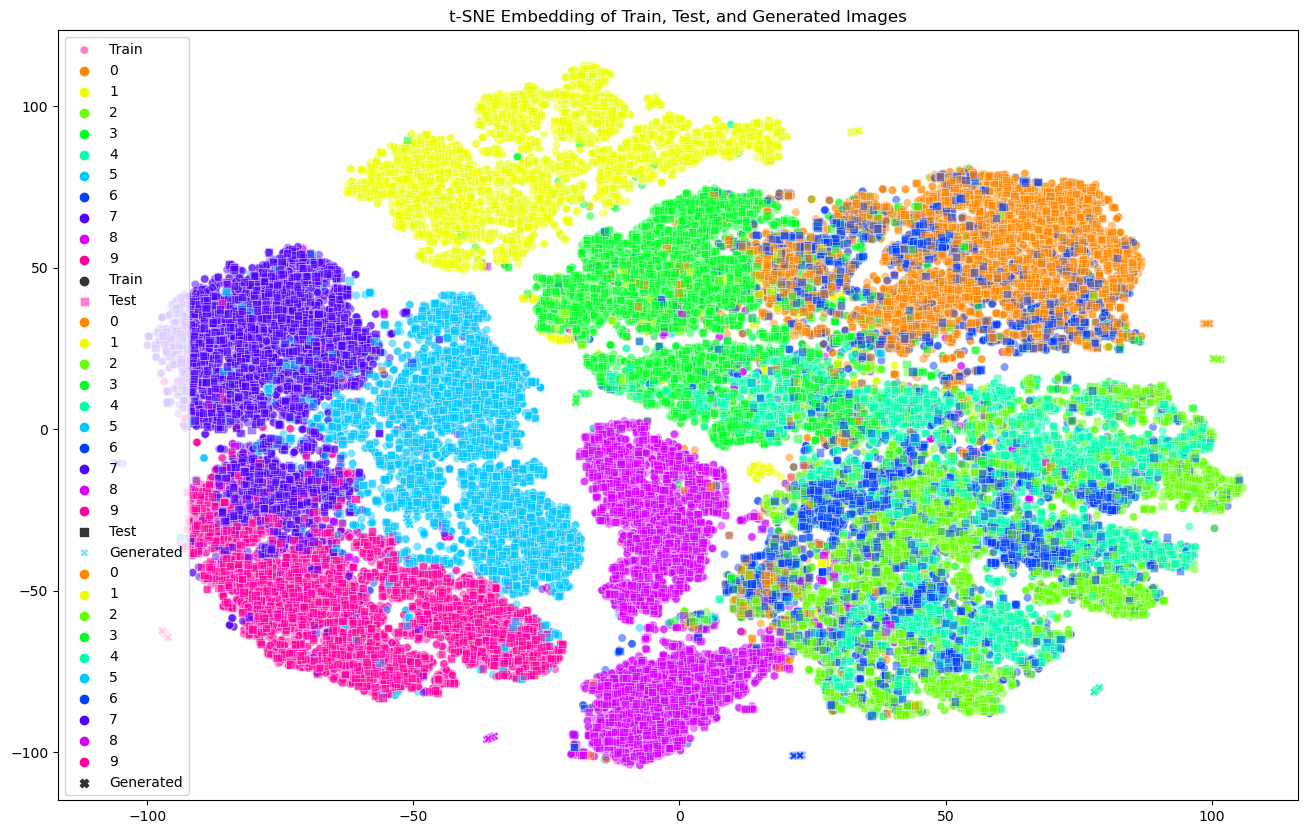

In [20]:
# Combine all features and labels
all_features = np.concatenate([train_features, test_features, generated_features])
all_labels = np.concatenate([train_labels, test_labels, generated_labels])
all_domains = np.concatenate([
    np.full(len(train_features), 'Train'),
    np.full(len(test_features), 'Test'),
    np.full(len(generated_features), 'Generated')
])

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(all_features)

# Separate the results for visualization
tsne_train = tsne_results[:len(train_features)]
tsne_test = tsne_results[len(train_features):len(train_features) + len(test_features)]
tsne_generated = tsne_results[len(train_features) + len(test_features):]

# Visualization
plt.figure(figsize=(16, 10))

# Plot Train Data
sns.scatterplot(
    x=tsne_train[:, 0], y=tsne_train[:, 1],
    hue=train_labels,
    palette=sns.color_palette("hsv", number_of_classes),
    style=np.full(len(train_labels), 'Train'),
    markers=["o"],
    legend="brief",
    alpha=0.5,
    label='Train'
)

# Plot Test Data
sns.scatterplot(
    x=tsne_test[:, 0], y=tsne_test[:, 1],
    hue=test_labels,
    palette=sns.color_palette("hsv", number_of_classes),
    style=np.full(len(test_labels), 'Test'),
    markers=["s"],
    legend="brief",
    alpha=0.5,
    label='Test'
)

# Plot Generated Data
sns.scatterplot(
    x=tsne_generated[:, 0], y=tsne_generated[:, 1],
    hue=generated_labels,
    palette=sns.color_palette("hsv", number_of_classes),
    style=np.full(len(generated_labels), 'Generated'),
    markers=["X"],
    legend="brief",
    alpha=0.5,
    label='Generated'
)

plt.title('t-SNE Embedding of Train, Test, and Generated Images')
plt.legend()
plt.show()